
# 📓 TeleConnect — Training & Evaluation with MLflow

This notebook documents **model training** and **evaluation** for the Telco Churn project.

> **Start MLflow UI first:**
> ```bash
> mlflow server \
> --backend-store-uri sqlite:///mlflow.db \
> --default-artifact-root ./mlruns \
> --host 127.0.0.1 \
> --port 5000
> ```

mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --host 127.0.0.1 --port 5000

In [1]:
from pathlib import Path
import sys, os
import mlflow
from mlflow.tracking import MlflowClient
import importlib
import json, pandas as pd
from IPython.display import display, Image

## 1) Environment & Paths

In [2]:
# === Project root & import path config (ensures imports from src/modules work) ===

NB_DIR = Path.cwd()
SRC_DIR = NB_DIR.parent
PROJECT_ROOT = SRC_DIR.parent

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from modules import modelBaselineMlflow as train_mod
from modules import modelEvaluation as eval_mod

# Common settings
PROC_DIR = str(PROJECT_ROOT / "data" / "processed")
MLFLOW_URI = "http://localhost:5000"
EXPERIMENT_NAME = "telco-churn-models"

print("MLFLOW_URI:", MLFLOW_URI)
print("EXPERIMENT:", EXPERIMENT_NAME)

MLFLOW_URI: http://localhost:5000
EXPERIMENT: telco-churn-models


## 2) Quick sanity check of processed data

In [3]:
files = [os.path.join(PROC_DIR, "train.csv"),
          os.path.join(PROC_DIR, "val.csv"),
          os.path.join(PROC_DIR, "test.csv")]

for p in files:
      if os.path.exists(p):
          print(p, "exists:", True)
      else:
        raise FileNotFoundError(f"File {p} does not exist.")

c:\Users\diego\Documents\UVG\10mo Semestre\MachineLearning\MlopsProject\data\processed\train.csv exists: True
c:\Users\diego\Documents\UVG\10mo Semestre\MachineLearning\MlopsProject\data\processed\val.csv exists: True
c:\Users\diego\Documents\UVG\10mo Semestre\MachineLearning\MlopsProject\data\processed\test.csv exists: True


In [4]:
NB_DIR = Path.cwd()                 # this is src/notebooks
MODULES_DIR = NB_DIR.parent / "modules"  # -> src/modules
if str(MODULES_DIR) not in sys.path:
    sys.path.append(str(MODULES_DIR))
print("Using modules dir:", MODULES_DIR)

Using modules dir: c:\Users\diego\Documents\UVG\10mo Semestre\MachineLearning\MlopsProject\src\modules


## 3) Train models with MLflow uses modelBaseline from modules

In [5]:
argv_bak = sys.argv
sys.argv = ["modelBaselineMlflow.py",
            "--proc_dir", PROC_DIR,
            "--mlflow_uri", MLFLOW_URI,
            "--experiment", EXPERIMENT_NAME]
try:
    train_mod.main()
finally:
    sys.argv = argv_bak

2025/11/14 15:16:24 INFO mlflow.tracking.fluent: Experiment with name 'telco-churn-models' does not exist. Creating a new experiment.


🏃 View run logreg at: http://localhost:5000/#/experiments/3/runs/d0c3a643a0ef49459f4e8dd958500043
🧪 View experiment at: http://localhost:5000/#/experiments/3
🏃 View run random_forest at: http://localhost:5000/#/experiments/3/runs/6e1087b0c024493794df1ff4e5f7e911
🧪 View experiment at: http://localhost:5000/#/experiments/3
🏃 View run xgboost at: http://localhost:5000/#/experiments/3/runs/975bf6e7077f48649562d22795b4705e
🧪 View experiment at: http://localhost:5000/#/experiments/3
🏃 View run lightgbm at: http://localhost:5000/#/experiments/3/runs/191beb0160ce4528ada2bdd705a8ebaf
🧪 View experiment at: http://localhost:5000/#/experiments/3


Successfully registered model 'teleconnect-churn-prod'.
2025/11/14 15:17:09 WARNING mlflow.tracking._model_registry.fluent: Run with id cfef9ee15e1a4c69b1f7e2b24c4f5426 has no artifacts at artifact path 'final_model', registering model based on models:/m-8d394b7c54924c169c6ce013ee820ae9 instead
2025/11/14 15:17:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: teleconnect-churn-prod, version 1


🏃 View run final_test_eval at: http://localhost:5000/#/experiments/3/runs/cfef9ee15e1a4c69b1f7e2b24c4f5426
🧪 View experiment at: http://localhost:5000/#/experiments/3
[OK] Entrenamiento y evaluación registrados en MLflow.


Created version '1' of model 'teleconnect-churn-prod'.


## 4) Load best run and print model name

In [6]:
# === Robust best-run selection + model loading using module function ===

mlflow.set_tracking_uri(MLFLOW_URI)
client = MlflowClient()

# Get experiment and best run by val_f1
exp = client.get_experiment_by_name(EXPERIMENT_NAME)
assert exp is not None, f"Experiment '{EXPERIMENT_NAME}' not found at {MLFLOW_URI}."
exp_id = exp.experiment_id

runs = client.search_runs([exp_id], order_by=["metrics.val_f1 DESC"], max_results=1)
assert runs, "No runs found. Train a model first."
best = runs[0]
best_run_id = best.info.run_id
print("Best run by val_f1:", best_run_id)

# Use the module's load_model_from_run function (has robust fallback logic)
# If best run is a TRAIN run it has 'model'; if it's 'final_test_eval', it has 'final_model'
try:
    model = eval_mod.load_model_from_run(best_run_id, model_stage="model")
    print("[OK] Model loaded successfully (from 'model' stage)")
except Exception as e:
    # Try final_model if model fails
    print(f"[INFO] Trying 'final_model' stage: {str(e)[:100]}")
    model = eval_mod.load_model_from_run(best_run_id, model_stage="final_model")
    print("[OK] Model loaded successfully (from 'final_model' stage)")

# Print estimator class if it's a pipeline with 'clf' step
try:
    if hasattr(model, "named_steps") and "clf" in model.named_steps:
        print("Estimator:", model.named_steps["clf"].__class__.__name__)
    else:
        print("Loaded object:", type(model).__name__)
except Exception as e:
    print("Introspection error:", e)

Best run by val_f1: 6e1087b0c024493794df1ff4e5f7e911
[OK] Model loaded successfully (from 'model' stage)
Estimator: RandomForestClassifier


## 5) Full evaluation (logs metrics & artifacts to MLflow)

In [7]:
# Evaluate and log everything (metrics + plots) to MLflow

# Reload the module to get the latest code with --skip_shap argument
importlib.reload(eval_mod)  # This reloads the module with the latest code

# 2) Call the module's main() by simulating CLI args
argv_bak = sys.argv
sys.argv = [
    "modelEvaluation.py",
    "--proc_dir", PROC_DIR,
    "--mlflow_uri", MLFLOW_URI,
    "--experiment", EXPERIMENT_NAME,

    # 👇 ensure we evaluate the exact run we just selected
    "--run_id", best_run_id,

    # the best run you loaded is a training run -> artifact subdir is 'model'
    "--model_stage", "model",

    # business + CV knobs
    "--n_splits", "5",
    "--avg_monthly_revenue", "850",
    "--intervention_cost", "25",
    "--intervention_rate", "0.30",
    "--retention_success_rate", "0.25",
    
    # 👇 Skip SHAP to avoid errors (temporary)
    "--skip_shap",
]
try:
    eval_mod.main()
finally:
    sys.argv = argv_bak

[INFO] SHAP analysis skipped (--skip_shap flag)
== Test metrics ==
accuracy: 0.7966
precision: 0.8298
recall: 0.2613
f1: 0.3975
roc_auc: 0.8694
== Business impact (net Q) == 78625.0
🏃 View run evaluation_module at: http://localhost:5000/#/experiments/3/runs/711637c256b2437f96f05021e3da07c9
🧪 View experiment at: http://localhost:5000/#/experiments/3
[OK] Evaluación completa registrada en MLflow.


Evaluation run_id: 711637c256b2437f96f05021e3da07c9


,value
test_accuracy,0.796559
test_precision,0.829787
test_recall,0.261307
test_f1,0.397452
test_roc_auc,0.869352
temporal_cv_f1_mean,0.185990
temporal_cv_roc_auc_mean,0.850863
bi_topk,697.000000
bi_true_churn_in_topk,452.000000
bi_retained_customers,113.000000


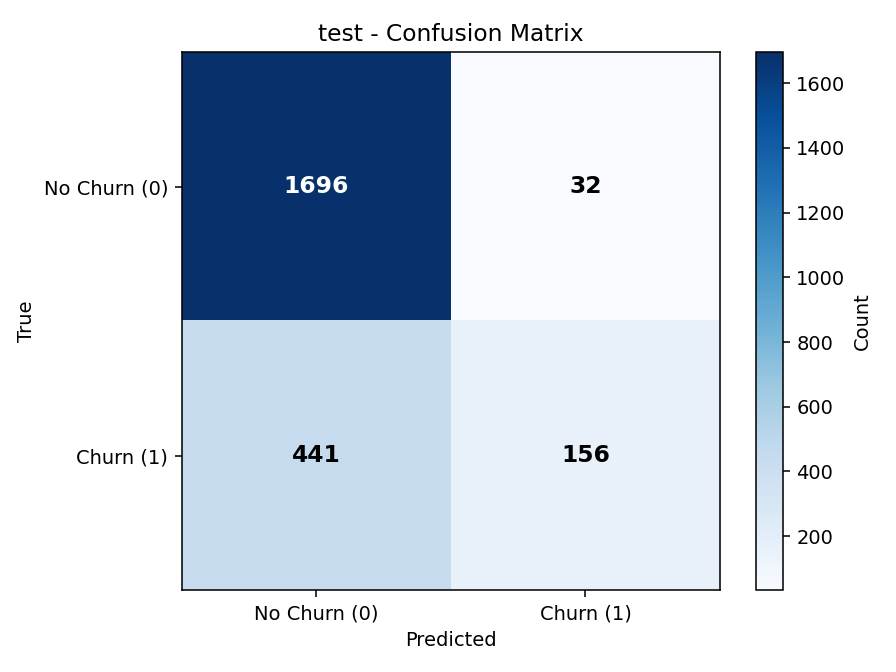

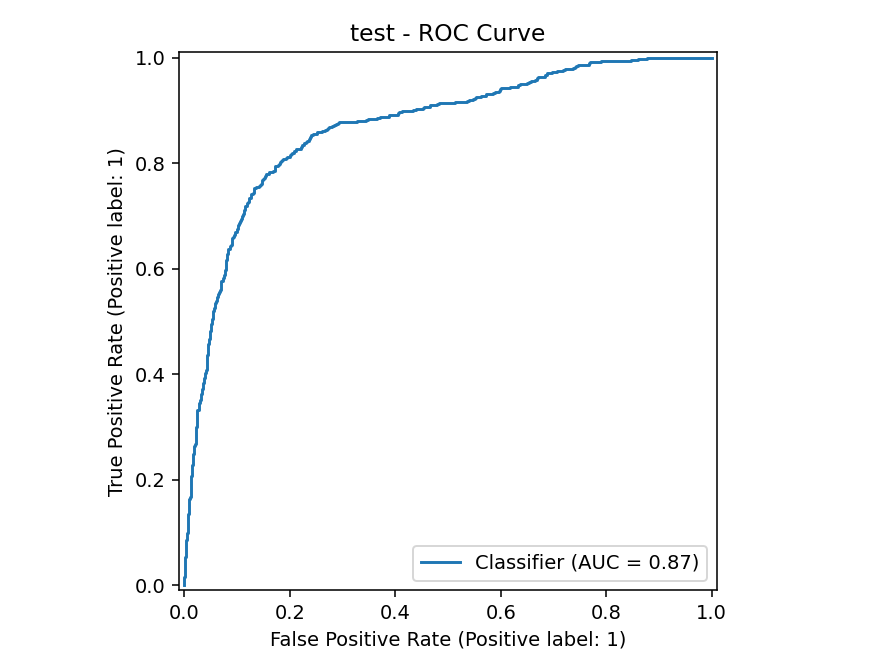

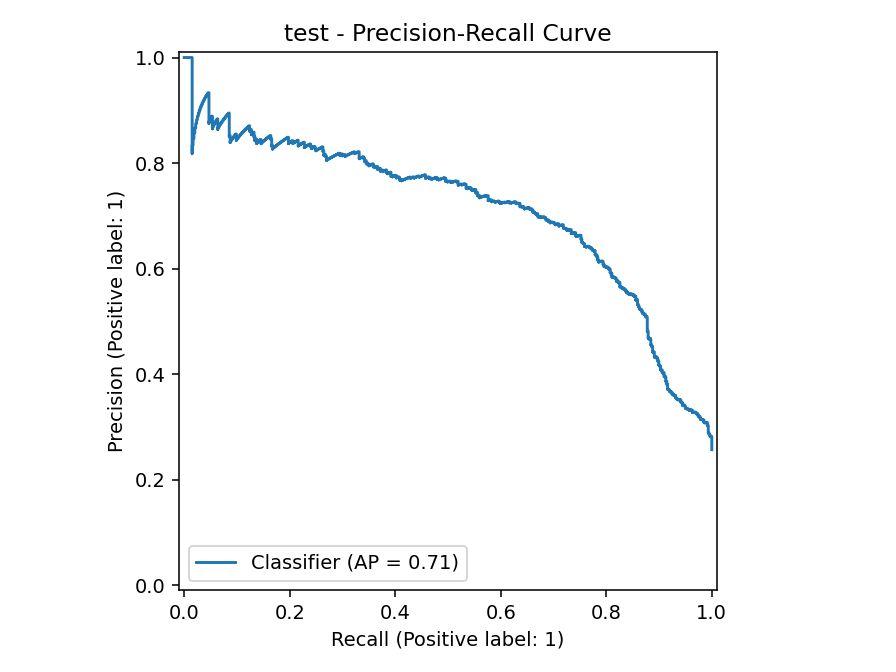


test_metrics.json:
{
  "accuracy": 0.7965591397849462,
  "precision": 0.8297872340425532,
  "recall": 0.2613065326633166,
  "f1": 0.3974522292993631,
  "roc_auc": 0.8693515804330293
}

business_impact.json:
{
  "n_samples": 2325,
  "k_targeted": 697,
  "top_rate": 0.3,
  "true_churn_in_topk": 452,
  "retention_success_rate": 0.25,
  "retained_customers": 113,
  "avg_monthly_revenue": 850.0,
  "intervention_cost": 25.0,
  "gross_benefit_q": 96050.0,
  "intervention_cost_total_q": 17425.0,
  "net_impact_q": 78625.0
}


In [8]:
# 📊 Fetch the latest "evaluation_module" run and display key metrics + plots in the notebook

client = MlflowClient()
exp = client.get_experiment_by_name(EXPERIMENT_NAME)
assert exp is not None, f"Experiment '{EXPERIMENT_NAME}' not found."

# get most recent evaluation run
runs = client.search_runs(
    [exp.experiment_id],
    filter_string="tags.mlflow.runName = 'evaluation_module'",
    order_by=["attributes.start_time DESC"],
    max_results=1
)
assert runs, "No evaluation_module run found. Run the evaluation cell first."
eval_run = runs[0]
eval_run_id = eval_run.info.run_id
print("Evaluation run_id:", eval_run_id)

# 1) Collect metrics directly from MLflow
metrics = eval_run.data.metrics  # a dict with all logged metrics
# pick the most relevant to show
pick = {k:v for k,v in metrics.items() if k.startswith("test_") or k.startswith("temporal_cv_") or k.startswith("bi_")}
df_metrics = pd.DataFrame([pick]).T
df_metrics.columns = ["value"]
display(df_metrics)

# 2) Download + show artifacts (confusion matrix, ROC, PR, metrics.json, business_impact.json)
dst = Path("src/notebooks/mlruns_artifacts") / eval_run_id
dst.mkdir(parents=True, exist_ok=True)

# helper to download and maybe display an image
def get_artifact(path_rel, show_image=False):
    try:
        local_path = client.download_artifacts(eval_run_id, path_rel, dst_path=str(dst))
        if show_image:
            display(Image(filename=local_path))
        return local_path
    except Exception as e:
        print(f"[skip] {path_rel}: {e}")

# images
get_artifact("test_confusion_matrix.png", show_image=True)
get_artifact("test_roc.png", show_image=True)
get_artifact("test_pr.png", show_image=True)

# JSONs
test_metrics_json = get_artifact("test_metrics.json", show_image=False)
bi_json = get_artifact("business_impact.json", show_image=False)

# pretty print JSONs if present
for p in [test_metrics_json, bi_json]:
    if p:
        with open(p) as f:
            print(f"\n{Path(p).name}:")
            print(json.dumps(json.load(f), indent=2))